# GenCode Explore

Explore the human RNA sequences from GenCode.

Assume user downloaded files from GenCode 38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

Improve on GenCode_Explore_101.ipynb

Use ORF_counter. 

Use MatPlotLib to make box plots and heat maps.

In [1]:
import time 
def show_time():
    t = time.time()
    s = time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))
    print(s)
show_time()

2021-07-12 15:45:57 UTC


In [2]:
import numpy as np
import pandas as pd
import gzip
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


In [3]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'

## Load the GenCode data.
Warning: GenCode has
over 100K protein-coding RNA (mRNA) 
and almost 50K non-coding RNA (lncRNA).

In [4]:
# Full GenCode ver 38 human is 106143 pc + 48752 nc and loads in 7 sec.
# Expect fewer transcripts if special filtering is used.
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
show_time()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
show_time()
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

2021-07-12 15:46:23 UTC
PC seqs loaded: 70825
2021-07-12 15:46:29 UTC
NC seqs loaded: 48752
2021-07-12 15:46:31 UTC


###OPTIONS
---

In [5]:
SAMPLE_FRACTION = 0.5
REPRODUCABILITY_SEED = 314159 #Not used in Random_Base_Oracle or PlotGenerator
NUM_BINS = 3
BINNING_SCALE = 100
NUMBER_OF_SIM_SEQUENCES_PER_BIN = 100

###Take sample of mRNA and lncRNA sequence data sets
---

In [6]:
pcdf_sample = pcdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED) #Take a sample of a fraction of the mRNA data frame
ncdf_sample = ncdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED) #Take a sample of a fraction of the lncRNA data frame
print('Sample size of mRNA sequences:', len(pcdf_sample))
print('Sample size of lncRNA sequences:', len(ncdf_sample))
show_time()

Sample size of mRNA sequences: 35412
Sample size of lncRNA sequences: 24376
2021-07-12 15:46:31 UTC


###Generate bins
---

In [7]:
bins = []
for b in range(1, NUM_BINS + 1):
  bin = (2 ** (b) * BINNING_SCALE, 2 ** (b + 1) * BINNING_SCALE)
  bins.append(bin)
print('Bins generated:', bins)
show_time()

Bins generated: [(200, 400), (400, 800), (800, 1600)]
2021-07-12 15:46:31 UTC


###Generate random RNA sequences

---

In [8]:
random.seed(REPRODUCABILITY_SEED)
sim_pc_sequences = []
sim_nc_sequences = []
for bin in bins:
  seq_len = (bin[0] + bin[1]) >> 1 #integer division using // apparently still calculates remainder, source: https://stackoverflow.com/questions/37053379/times-two-faster-than-bit-shift-for-python-3-x-integers
  cds_len = seq_len >> 1 #So instead use right bit shift
  print('Sequence length:',seq_len)
  rbo = Random_Base_Oracle(seq_len, debug=True)
  temp_pc, temp_nc = rbo.get_partitioned_sequences(cds_len, NUMBER_OF_SIM_SEQUENCES_PER_BIN)
  sim_pc_sequences += temp_pc
  sim_nc_sequences += temp_nc
print('mRNA sequences generated:', NUMBER_OF_SIM_SEQUENCES_PER_BIN * NUM_BINS)
print('lncRNA sequences generated:', NUMBER_OF_SIM_SEQUENCES_PER_BIN * NUM_BINS)
show_time()

Sequence length: 300
It took 739 trials to reach 100 per class.
Sequence length: 600
It took 3755 trials to reach 100 per class.
Sequence length: 1200
It took 211337 trials to reach 100 per class.
mRNA sequences generated: 300
lncRNA sequences generated: 300
2021-07-12 15:48:50 UTC


###Bin sequences by sequence length
---

In [9]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [10]:
#Bin the RNA sequences
binned_pc_sequences = []
binned_nc_sequences = []
binned_sim_pc_sequences = []
binned_sim_nc_sequences = []
for i in range(0, NUM_BINS):
  bin = bins[i]
  binned_pc_sequences.append(subset_list_by_len_bounds(pcdf_sample['sequence'].tolist(), bin[0], bin[1]))
  binned_nc_sequences.append(subset_list_by_len_bounds(ncdf_sample['sequence'].tolist(), bin[0], bin[1]))
  binned_sim_pc_sequences.append(subset_list_by_len_bounds(sim_pc_sequences, bin[0], bin[1]))
  binned_sim_nc_sequences.append(subset_list_by_len_bounds(sim_nc_sequences, bin[0], bin[1]))
show_time()

2021-07-12 15:48:51 UTC


##Gather data on ORF lengths and the number of contained and non-contained ORFs

---

In [11]:
#TODO: optimize. combine data?
pc_max_len_data = np.empty(NUM_BINS, dtype=object)
pc_max_cnt_data = np.empty(NUM_BINS, dtype=object)
pc_contain_data = np.empty(NUM_BINS, dtype=object)
nc_max_len_data = np.empty(NUM_BINS, dtype=object)
nc_max_cnt_data = np.empty(NUM_BINS, dtype=object)
nc_contain_data = np.empty(NUM_BINS, dtype=object)
sim_pc_max_len_data = np.empty(NUM_BINS, dtype=object)
sim_pc_max_cnt_data = np.empty(NUM_BINS, dtype=object)
sim_pc_contain_data = np.empty(NUM_BINS, dtype=object)
sim_nc_max_len_data = np.empty(NUM_BINS, dtype=object)
sim_nc_max_cnt_data = np.empty(NUM_BINS, dtype=object)
sim_nc_contain_data = np.empty(NUM_BINS, dtype=object)

oc = ORF_counter()

for bin in range(0, NUM_BINS):
  pc_max_len_data[bin] = np.zeros(len(binned_pc_sequences[bin]))
  pc_max_cnt_data[bin] = np.zeros(len(binned_pc_sequences[bin]))
  pc_contain_data[bin] = np.zeros(len(binned_pc_sequences[bin]))
  nc_max_len_data[bin] = np.zeros(len(binned_nc_sequences[bin]))
  nc_max_cnt_data[bin] = np.zeros(len(binned_nc_sequences[bin]))
  nc_contain_data[bin] = np.zeros(len(binned_nc_sequences[bin]))
  sim_pc_max_len_data[bin] = np.zeros(len(binned_sim_pc_sequences[bin]))
  sim_pc_max_cnt_data[bin] = np.zeros(len(binned_sim_pc_sequences[bin]))
  sim_pc_contain_data[bin] = np.zeros(len(binned_sim_pc_sequences[bin]))
  sim_nc_max_len_data[bin] = np.zeros(len(binned_sim_nc_sequences[bin]))
  sim_nc_max_cnt_data[bin] = np.zeros(len(binned_sim_nc_sequences[bin]))
  sim_nc_contain_data[bin] = np.zeros(len(binned_sim_nc_sequences[bin]))
  #Gather protein-coding sequence data
  for seq in range(0, len(binned_pc_sequences[bin])):
    oc.set_sequence(binned_pc_sequences[bin][seq])
    pc_max_len_data[bin][seq] = oc.get_max_orf_len()
    pc_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    pc_contain_data[bin][seq] = oc.count_contained_orfs()

  #Gather non-coding sequence data
  for seq in range(0, len(binned_nc_sequences[bin])):
    oc.set_sequence(binned_nc_sequences[bin][seq])
    nc_max_len_data[bin][seq] = oc.get_max_orf_len()
    nc_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    nc_contain_data[bin][seq] = oc.count_contained_orfs()

  #Gather simulated pc sequence data
  for seq in range(0, len(binned_sim_pc_sequences[bin])):
    oc.set_sequence(binned_sim_pc_sequences[bin][seq])
    sim_pc_max_len_data[bin][seq] = oc.get_max_orf_len()
    sim_pc_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    sim_pc_contain_data[bin][seq] = oc.count_contained_orfs()

  #Gather simulated nc sequence data
  for seq in range(0, len(binned_sim_nc_sequences[bin])):
    oc.set_sequence(binned_sim_nc_sequences[bin][seq])
    sim_nc_max_len_data[bin][seq] = oc.get_max_orf_len()
    sim_nc_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    sim_nc_contain_data[bin][seq] = oc.count_contained_orfs()
show_time()

2021-07-12 15:48:59 UTC


###Calculate K-Mer Frequencies

---

In [12]:
MAX_K = 3
kt = KmerTools()
pc_counts = kt.make_dict_upto_K(MAX_K)
for sample in pcdf_sample['sequence']:
  kt.update_count_one_K(pc_counts, MAX_K, sample, True)
kt.harvest_counts_from_K(pc_counts, MAX_K)
pc_freqs = kt.count_to_frequency(pc_counts, MAX_K)

nc_counts = kt.make_dict_upto_K(MAX_K)
for sample in ncdf_sample['sequence']:
  if 'N' not in sample: #For some reason one of the samples has an N in it
    kt.update_count_one_K(nc_counts, MAX_K, sample, True)
kt.harvest_counts_from_K(nc_counts, MAX_K)
nc_freqs = kt.count_to_frequency(nc_counts, MAX_K)

pc_k_mer_freqs = [[], [], []]
nc_k_mer_freqs = [[], [], []]
k_mer_names = [[], [], []]
for key in pc_freqs:
  pc_k_mer_freqs[len(key) - 1].append(pc_freqs[key])
  nc_k_mer_freqs[len(key) - 1].append(nc_freqs[key])
  k_mer_names[len(key) - 1].append(key)

In [13]:
for i in range(3):
  pc_k_mer_freqs[i] = np.asarray(pc_k_mer_freqs[i])
  nc_k_mer_freqs[i] = np.asarray(nc_k_mer_freqs[i])

###Prepare data for plot of bin sizes

---

In [14]:
pc_bin_sizes = np.zeros(NUM_BINS)
nc_bin_sizes = np.zeros(NUM_BINS)
sim_pc_bin_sizes = np.zeros(NUM_BINS)
sim_nc_bin_sizes = np.zeros(NUM_BINS)
for i in range(0, NUM_BINS):
  pc_bin_sizes[i] = len(binned_pc_sequences[i])
  nc_bin_sizes[i] = len(binned_nc_sequences[i])
  sim_pc_bin_sizes[i] = len(binned_sim_pc_sequences[i])
  sim_nc_bin_sizes[i] = len(binned_sim_nc_sequences[i])
show_time()

2021-07-12 15:49:53 UTC


###Prepare data for plot of number of sequences with no ORFs and plot of number of sequences with max ORF lengths equal to or less than 100

---

In [15]:
"""
Count the number of values in a given data set that are within a given inclusive range.
"""
def count_data_in_range(data, min, max):
  return np.sum((data >= min) & (data <= max))

In [16]:
pc_no_orf_count = np.zeros(NUM_BINS)
nc_no_orf_count = np.zeros(NUM_BINS)
sim_pc_no_orf_count = np.zeros(NUM_BINS)
sim_nc_no_orf_count = np.zeros(NUM_BINS)
pc_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
nc_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
sim_pc_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
sim_nc_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
for i in range(0, NUM_BINS):
  pc_no_orf_count[i] = count_data_in_range(pc_max_len_data[i], 0, 0)
  nc_no_orf_count[i] = count_data_in_range(nc_max_len_data[i], 0, 0)
  sim_pc_no_orf_count[i] = count_data_in_range(sim_pc_max_len_data[i], 0, 0)
  sim_nc_no_orf_count[i] = count_data_in_range(sim_nc_max_len_data[i], 0, 0)
  pc_max_orf_len_less_than_100[i] = count_data_in_range(pc_max_len_data[i], 0, 100)
  nc_max_orf_len_less_than_100[i] = count_data_in_range(nc_max_len_data[i], 0, 100)
  sim_pc_max_orf_len_less_than_100[i] = count_data_in_range(sim_pc_max_len_data[i], 0, 100)
  sim_nc_max_orf_len_less_than_100[i] = count_data_in_range(sim_nc_max_len_data[i], 0, 100)

show_time()

2021-07-12 15:49:53 UTC


## Plot the data

---

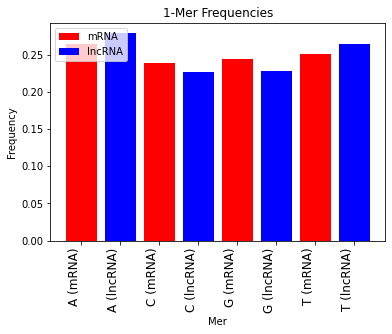

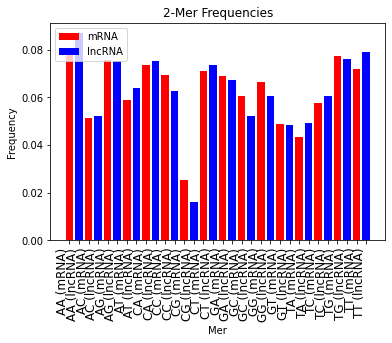

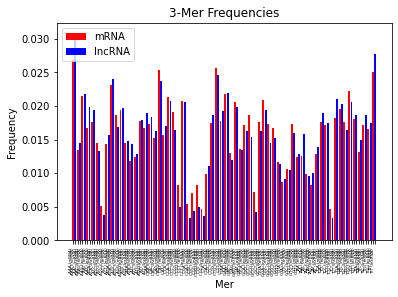

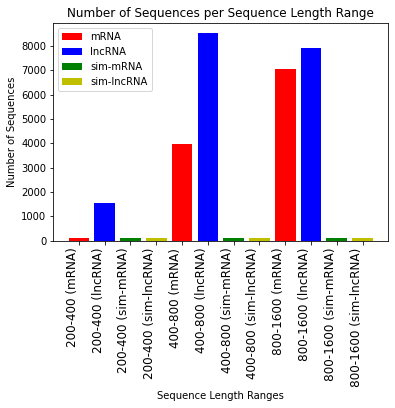

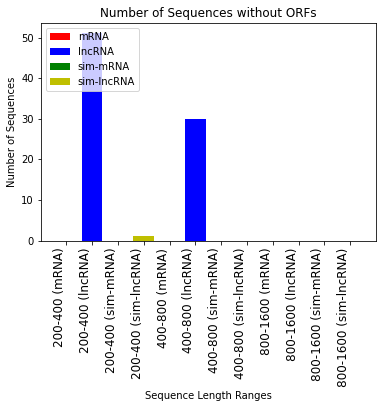

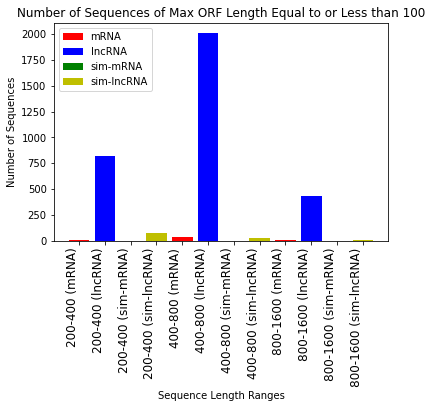

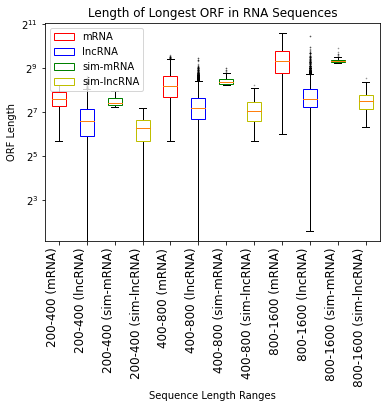

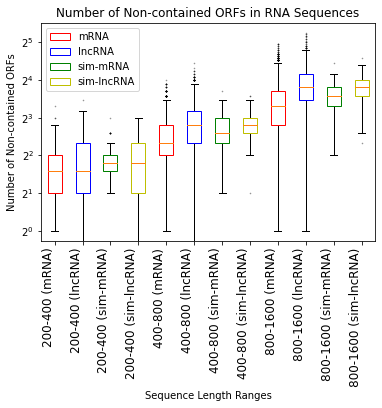

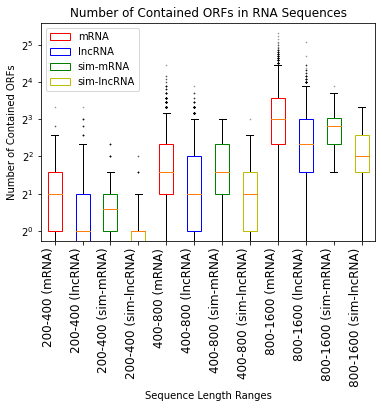

In [20]:
#Generate x-axis labels
x_axis_labels = []
for bin in bins:
  x_axis_labels.append(str(bin[0]) + "-" + str(bin[1]))

data_set_names = ['mRNA', 'lncRNA', 'sim-mRNA', 'sim-lncRNA']

#Set up plot generator
pg = PlotGenerator()
pg.set_text_options(90, 'right', 0, 'center', 12)

pg.set_text('1-Mer Frequencies', 'Mer', 'Frequency', k_mer_names[0], None)
pg.bar_plot([pc_k_mer_freqs[0], nc_k_mer_freqs[0]], ['mRNA', 'lncRNA'])

pg.set_text('2-Mer Frequencies', 'Mer', 'Frequency', k_mer_names[1], None)
pg.bar_plot([pc_k_mer_freqs[1], nc_k_mer_freqs[1]], ['mRNA', 'lncRNA'])

pg.set_text_options(90, 'right', 0, 'center', 4)
pg.set_text('3-Mer Frequencies', 'Mer', 'Frequency', k_mer_names[2], None)
pg.bar_plot([pc_k_mer_freqs[2], nc_k_mer_freqs[2]], ['mRNA', 'lncRNA'])

pg.set_text_options(90, 'right', 0, 'center', 12)

#Bar plots
pg.set_text('Number of Sequences per Sequence Length Range', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_bin_sizes, nc_bin_sizes, sim_pc_bin_sizes, sim_nc_bin_sizes], data_set_names)

pg.set_text('Number of Sequences without ORFs', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_no_orf_count, nc_no_orf_count, sim_pc_no_orf_count, sim_nc_no_orf_count], data_set_names)

pg.set_text('Number of Sequences of Max ORF Length Equal to or Less than 100', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_max_orf_len_less_than_100, nc_max_orf_len_less_than_100, sim_pc_max_orf_len_less_than_100, sim_nc_max_orf_len_less_than_100], data_set_names)

#Box plots
pg.set_axis_options('linear', 10, 'log', 2)

pg.set_text('Length of Longest ORF in RNA Sequences', 'Sequence Length Ranges', 'ORF Length', x_axis_labels, None)
pg.box_plot([pc_max_len_data, nc_max_len_data, sim_pc_max_len_data, sim_nc_max_len_data], data_set_names, True)

pg.set_text('Number of Non-contained ORFs in RNA Sequences', 'Sequence Length Ranges', 'Number of Non-contained ORFs', x_axis_labels, None)
pg.box_plot([pc_max_cnt_data, nc_max_cnt_data, sim_pc_max_cnt_data, sim_nc_max_cnt_data], data_set_names, True)

pg.set_text('Number of Contained ORFs in RNA Sequences', 'Sequence Length Ranges', 'Number of Contained ORFs', x_axis_labels, None)
pg.box_plot([pc_contain_data, nc_contain_data, sim_pc_contain_data, sim_nc_contain_data], data_set_names, True)

## Plotting examples
[boxplot doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)  
[boxplot demo](https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html)  
[heatmap examples](https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib) - scroll down!  